# A simple MCMC algorithm
Palermo Penano

* What is MCMC?
* What are some of its applications??
* What problems does it solve?
* How is it used in Bayesian statistics?
* What are its output?

This notebook follows the implementation of this blog post: https://twiecki.io/blog/2015/11/10/mcmc-sampling/

In [69]:
%matplotlib inline

import warnings

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm


warnings.filterwarnings('ignore')
sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

Generate data from the normal distribution centered around zero
In reality, we do not know the true distribution of the data that have generated below but we can use MCMC to approximate this unknown distribution

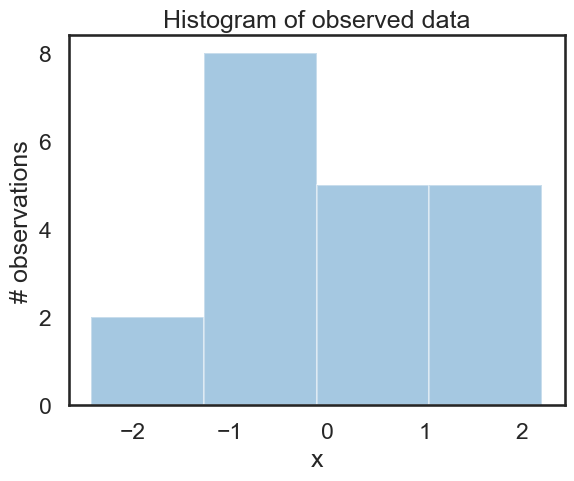

In [70]:
data = np.random.randn(20)
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

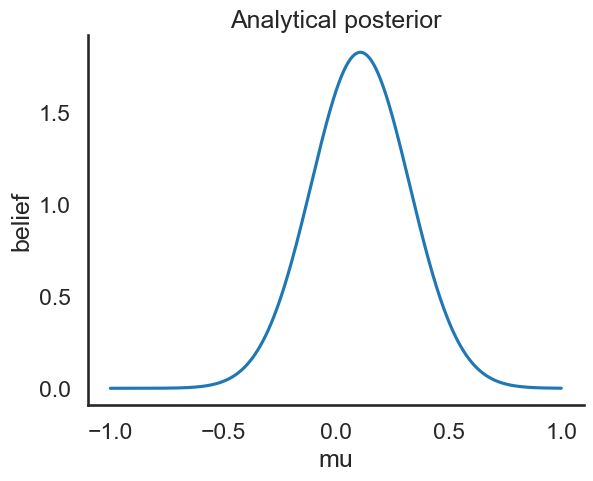

In [4]:
# See the parameters for the normal with known sigma in the table in this Wikipedia page
# https://en.wikipedia.org/wiki/Conjugate_prior#Practical_example

def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

# Metropolis MCMC Sampling

Here's a summary of the `sampler` function below that implements a simple MCMC sampler:

1. Specify the sample size you want to generate from the posterior by setting the value in the `samples` parameter.
2. In a for loop that runs for n=`samples` iterations, do the following:
    1. Generate a value for a mu you want to propose as an update from the current mu
    2. Calculate the likelihood using your data for both the current mu and proposed mu
    3. Calculate the prior probabilities for both the current and proposed mu
    4. Using the likelihood and prior probabilities calculated above, calculate the posterior probabilities for both the current and the proposed mu.
    5. Use the calculated prior probabilities and apply the accept-reject criteria to determine whether we update the current mu to the proposed mu.
    6. Save the value of mu we end up choosing after applying the accept-reject criteria.

In step 2.D, the formula used to calculate the posterior is `P(mu | data) ~ P(data | mu) * P(mu)`, which is the nominator in Baye's theorem. We ignore the denominator because it is generally difficult to calculate, doesn't depend on mu, and ends up cancelling out anyway when we apply the accep-reject criteria for deciding when we want to update the current mu (in the function below, you'll see that we take the ratio of the posterior for the current mu and proposed mu to determine the acceptance threshold. Since the denominator is the same for both---it is just P(data) after all---it cancels out).

The sampler implemented here is one that hardcodes a specific prior and likelihood, namely, the normal distribution. 

In general applications, these distributions could be non-normal and different from each other. For example, suppose we were trying to estimate conversion rate (i.e. the number of customers who sign up), then a prior we might consider for the conversion rate is the Beta distribution. The likelihood could then be the Binomial distribution since the outcome we are observing are counts of successes (again, the number of customers who signed up)

In [41]:
def sampler(
    data, 
    samples=4, 
    mu_init=0.5, 
    proposal_width=0.5, 
    plot=False, 
    mu_prior_mu=0,
    mu_prior_sd=1.
):
    mu_current = mu_init
    posterior = [mu_current]
    
    for i in range(samples):

        # Generate a candidate value for mu that is not too different
        # from the `mu` from the previous step. If we want `mu_proposal` to be
        # very different, then we can set a large `proposal_width` value
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute the likelihood function (the probability of observing `data` for given value for `mu`)
        # for both the current mu and and new mu, `mu_proposal`, for this step.
        # The likelihood will serves as our "objective function". 
        # 
        # Note that we have assumed we know that the standard deviation is 1. In this exercise, 
        # we are only interested in generating the posterior distribution for mean and 
        # not the standard deviation.
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

        # Compute the prior probability of current and proposed mu
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

        # Nominator of Bayes formula
        # Note that the denominator is just P(data) and because it doesn't depend
        # on the parameter we want to estimate (namely, mu), we can exclude it
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal

        # Accept-reject criteria
        # We only accept without question the proposed mu if it results in a likelihood
        # that is greater than the likelihood from the current mu
        # If, otoh, p_accept < 1, then we only accept the proposed mu only 50% of the time
        p_accept = p_proposal / p_current
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(
                mu_current, 
                mu_proposal, 
                mu_prior_mu, 
                mu_prior_sd, 
                data, 
                accept, 
                posterior, 
                i
            )
        
        if accept:
            mu_current = mu_proposal
            
        posterior.append(mu_current)
        
    return np.array(posterior)

In [42]:
# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
#     plt.legend()

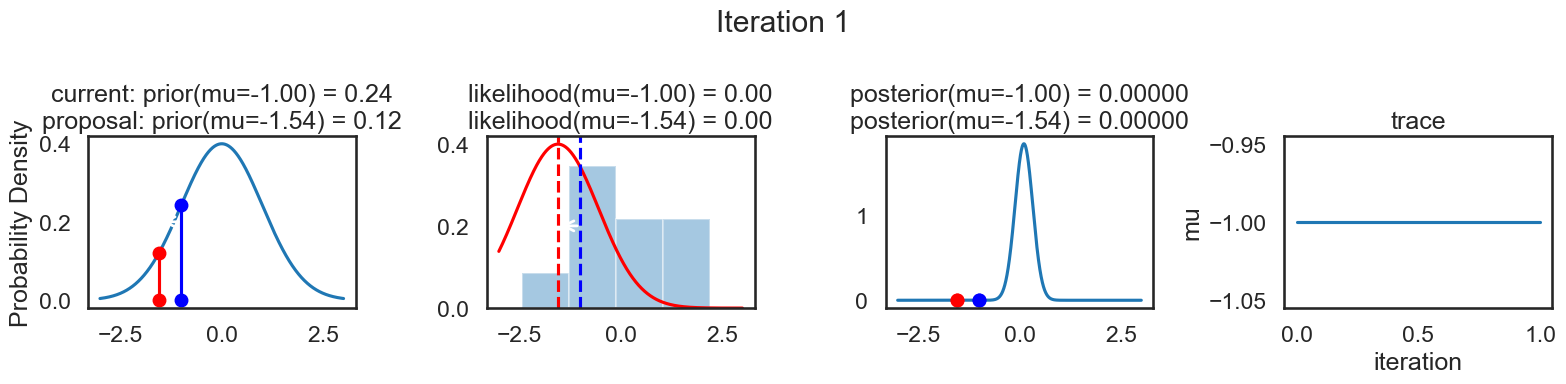

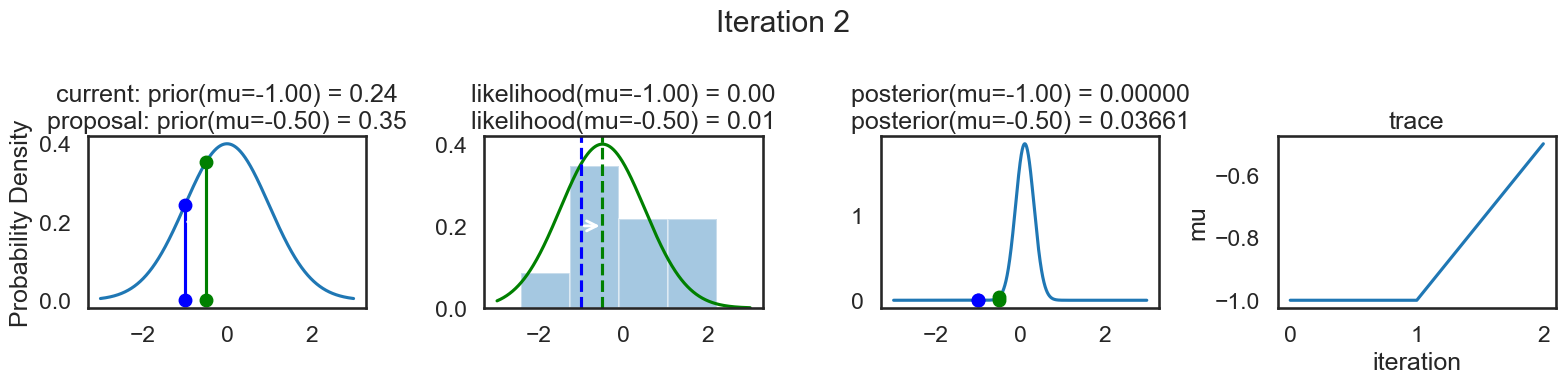

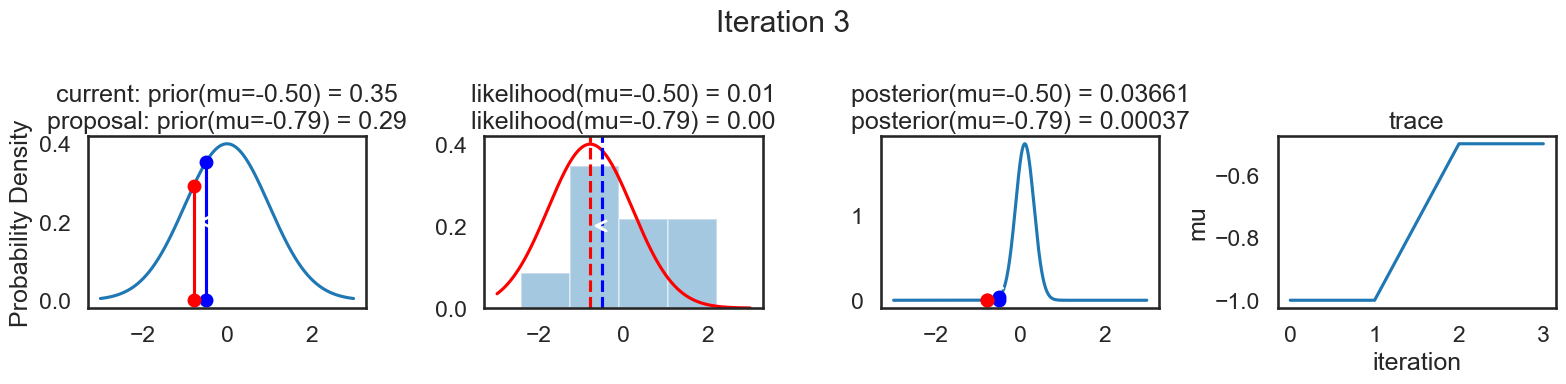

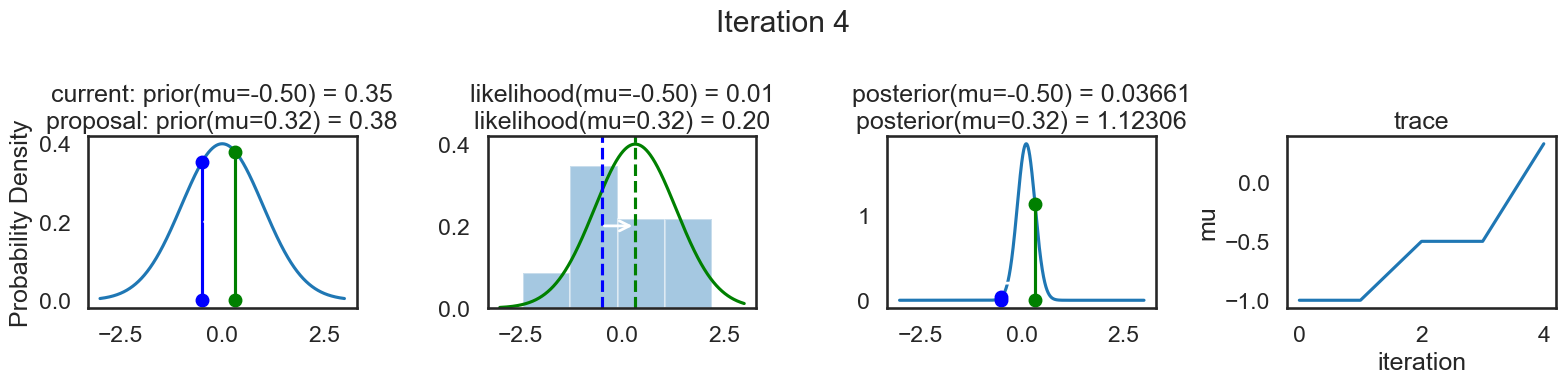

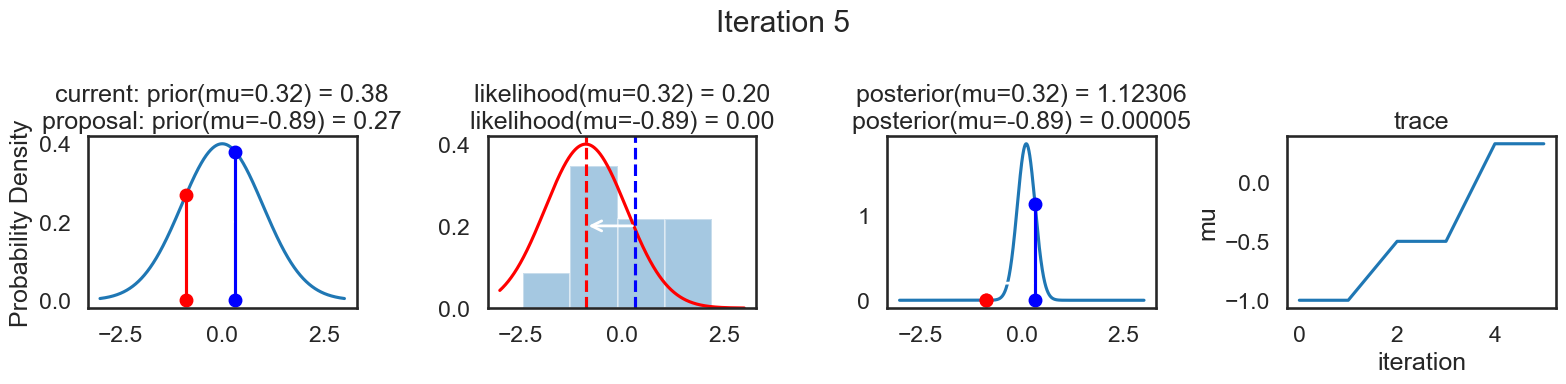

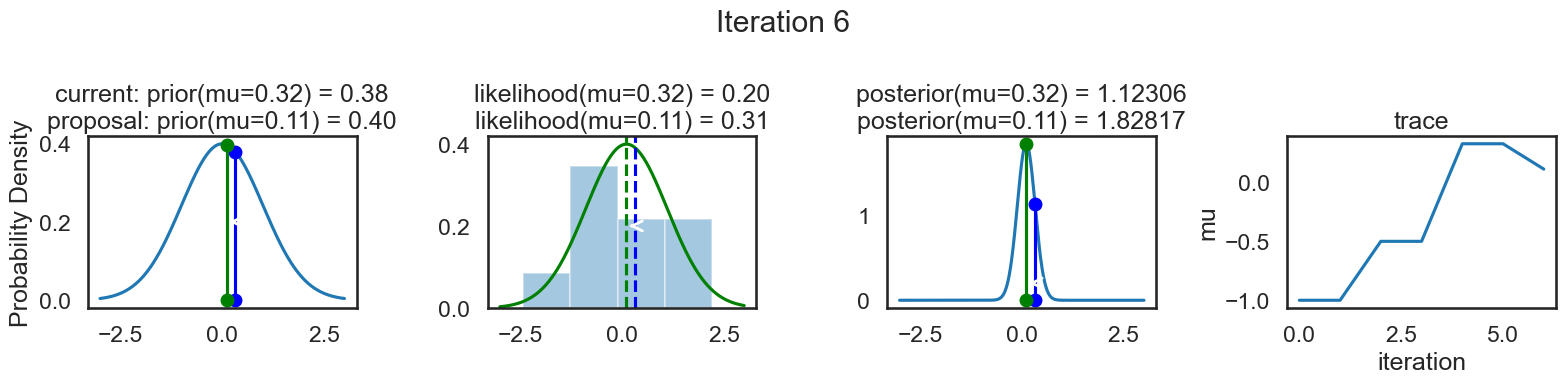

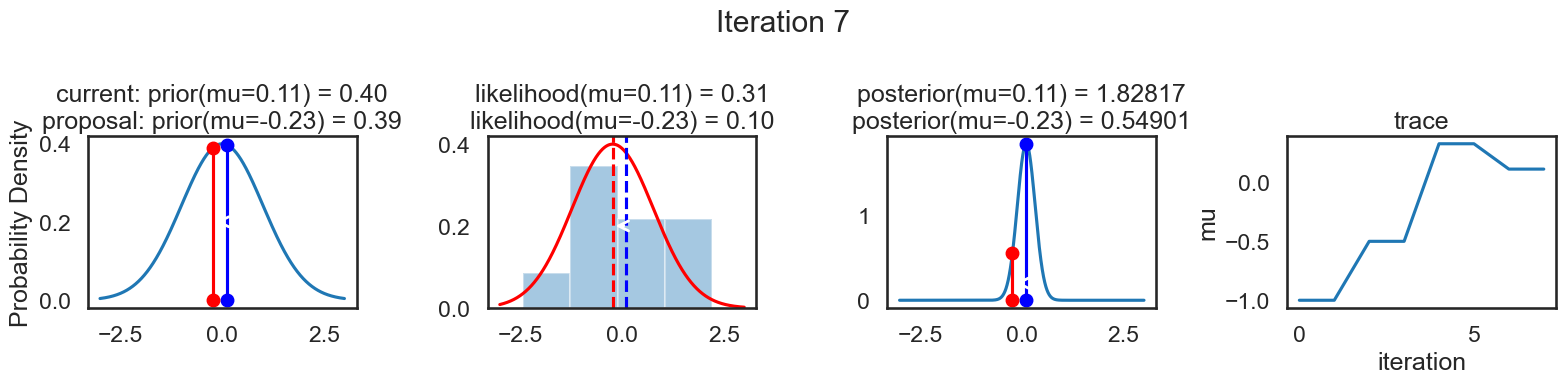

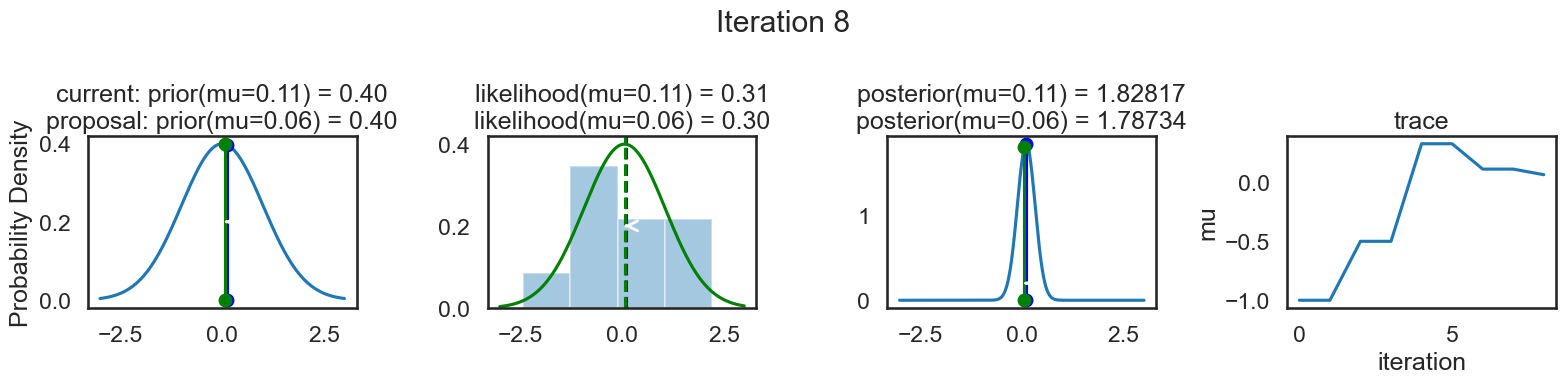

In [43]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

## Trace plots for different number of sample sizes

The sample size here refers to samples from the posterior distribution. When samples = 10, we are only running MCMC 10 times and generating 10 observations from the posterior distribution. Ideally, we run MCMC thousands of times to generates thousands of values from the posterior distribution.

===== Generating posterior for 10 samples =====


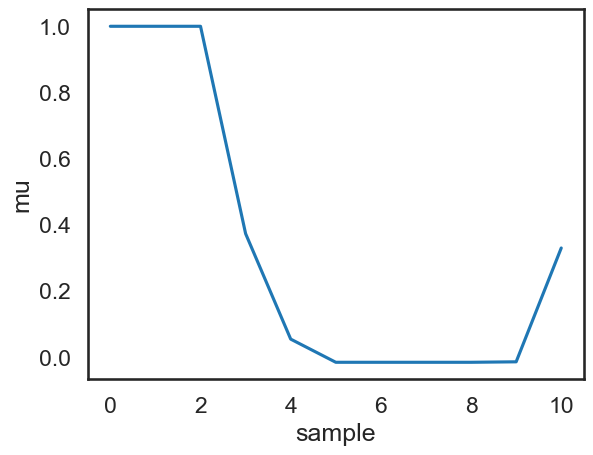

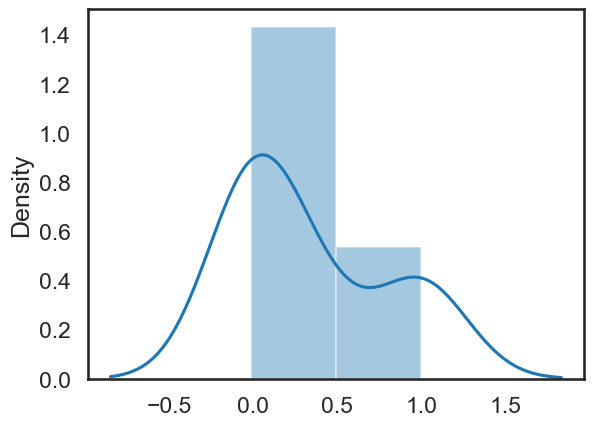

===== Generating posterior for 100 samples =====


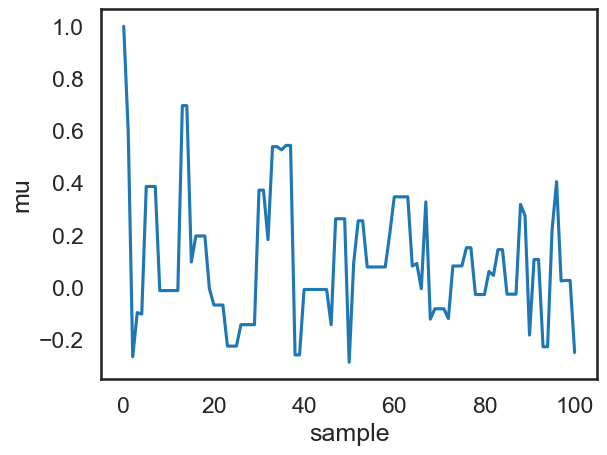

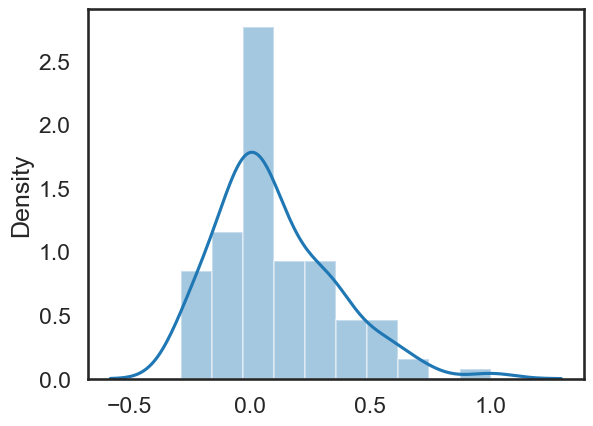

===== Generating posterior for 1000 samples =====


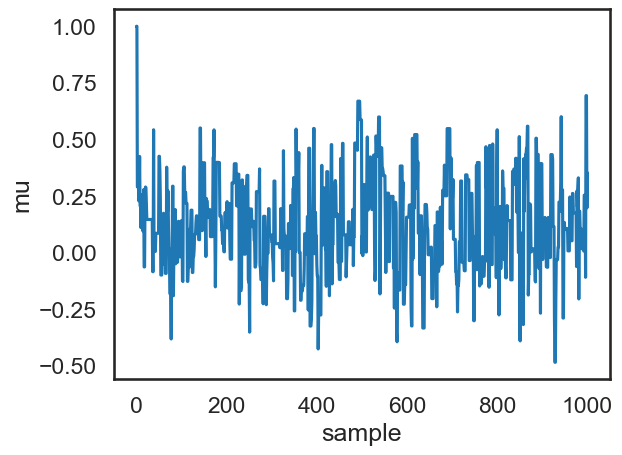

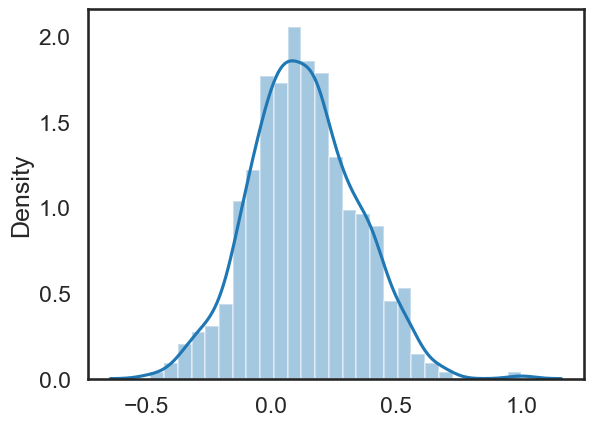

In [71]:
for runs in [10, 100, 1000]:
    print(f"===== Generating posterior for {runs} samples =====")
    posterior = sampler(data, samples=runs, mu_init=1.)
    
    fig, ax = plt.subplots()
    ax.plot(posterior)
    _ = ax.set(xlabel='sample', ylabel='mu')
    plt.show()
    
    ax1 = plt.subplot()
    sns.distplot(posterior, ax=ax1, label='estimated posterior')
    plt.show()

## Final output of an MCMC simulation

Here we plot the estimated posterior using the samples generated by MCMC along with the analytical posterior (which is unobserved in real applications). We see that, given our guess on the prior distribution and the small amount of data we had (stored in `data`), we were able to generate a pretty good estimate of the distribution for `mu`.

/Users/pspenano/miniconda3/envs/ml_notes/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


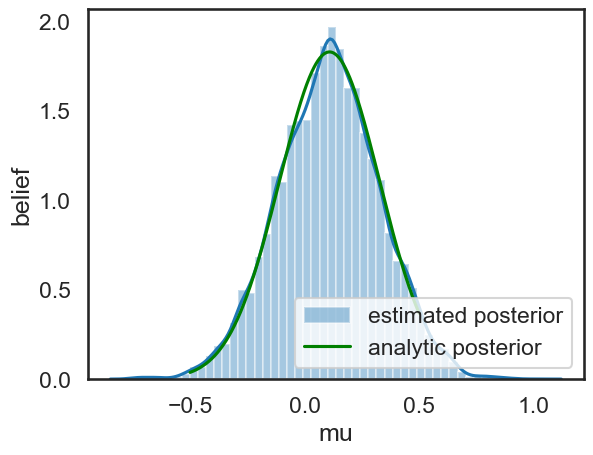

In [57]:
ax = plt.subplot()

# Note that we omit the first 500 samples generated by MCMC. These are the burn-in
# samples the values for which tend to be inaccurate as they were the first few
# samples generated by the MCMC simulation
sns.distplot(posterior[500:], ax=ax, label='estimated posterior')

x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')

_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();